# pipeline

https://www.tensorflow.org/lite/tutorials/pose_classification

In [1]:
# pip install -q opencv-python

In [2]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.utils.discovery import all_displays

In [3]:
def load_pose_landmarks(csv_path):
    """Loads a CSV created by MoveNetPreprocessor.

    Returns:
      X: Detected landmark coordinates and scores of shape (N, 25 * 4)
      y: Ground truth labels of shape (N, label_count = 30)
      classes: The list of all class names found in the dataset
      dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
        truth labels (y) to use later to train a pose classification model.
    """
    col_to_remove = [
        "LEFT_KNEE_x",
        "LEFT_KNEE_y",
        "LEFT_KNEE_z",
        "LEFT_KNEE_visibility",
        "RIGHT_KNEE_x",
        "RIGHT_KNEE_y",
        "RIGHT_KNEE_z",
        "RIGHT_KNEE_visibility",
        "LEFT_ANKLE_x",
        "LEFT_ANKLE_y",
        "LEFT_ANKLE_z",
        "LEFT_ANKLE_visibility",
        "RIGHT_ANKLE_x",
        "RIGHT_ANKLE_y",
        "RIGHT_ANKLE_z",
        "RIGHT_ANKLE_visibility",
        "LEFT_HEEL_x",
        "LEFT_HEEL_y",
        "LEFT_HEEL_z",
        "LEFT_HEEL_visibility",
        "RIGHT_HEEL_x",
        "RIGHT_HEEL_y",
        "RIGHT_HEEL_z",
        "RIGHT_HEEL_visibility",
        "LEFT_FOOT_INDEX_x",
        "LEFT_FOOT_INDEX_y",
        "LEFT_FOOT_INDEX_z",
        "LEFT_FOOT_INDEX_visibility",
        "RIGHT_FOOT_INDEX_x",
        "RIGHT_FOOT_INDEX_y",
        "RIGHT_FOOT_INDEX_z",
        "RIGHT_FOOT_INDEX_visibility",
    ]

    # Load the CSV file
    dataframe = pd.read_csv(csv_path, index_col=0, delimiter=";")
    df_to_process = dataframe.copy()
    target_all = pd.Series(
        [df_to_process.loc[i][0].split("/")[1] for i in range(len(df_to_process))]
    )

    classes_to_store = ["base_pose", "shooter_pose"]

    # classes  = ['interacting_with_phone', 'reading_newspaper', 'sitting_still', ]
    target = [target_i for target_i in target_all if target_i in classes_to_store]
    le = LabelEncoder()
    le.fit(target)

    # Drop the file_name columns as you don't need it during training.
    df_to_process.drop(columns=["image_path", "image_viz_path"], inplace=True)
    df_to_process = df_to_process.drop(col_to_remove, axis=1)
    df_to_process["label"] = target_all
    df_to_process = df_to_process.loc[
        [x in classes_to_store for x in df_to_process["label"]]
    ]

    X = df_to_process
    X = X.drop(["label"], axis=1)

    # Extract the labels
    y = le.transform(target)

    # Convert the input features and labels into the correct format for training.
    X = X.astype("float64")
    # y = keras.utils.to_categorical(y)

    return X, y, classes_to_store

In [4]:
# define PyTorch dataloader
class MatrixDataset(Dataset):
    def __init__(self, X, y, class_names):
       self.data = X.to_numpy(dtype=np.float32)
       self.target = y
       self.class_names = class_names
       
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.target[idx]
        return data, label

In [5]:
# define PyTorch Lightning
class ClassificationDataModule(pl.LightningDataModule):
    def __init__(
        self,
        annotation_csv_file,
        train_val_split,
        test_val_split,
        batch_size,
        num_workers,
    ):
        super().__init__()

        # задаем параметры даталоадера
        self.batch_size = batch_size
        self.num_workers = num_workers

        # задаем данные датасета
        X, y, class_names = load_pose_landmarks(annotation_csv_file)

        # Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=train_val_split, random_state=42, stratify=y
        )

        X_val, X_test, y_val, y_test = train_test_split(
            X_val, y_val, test_size=test_val_split, random_state=42, stratify=y_val
        )

        self.train = MatrixDataset(X_train, y_train, class_names)
        self.val = MatrixDataset(X_val, y_val, class_names)
        self.test = MatrixDataset(X_test, y_test, class_names)

    def prepare_data(self):
        pass

    def train_dataloader(self):
        return DataLoader(
            self.train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )

In [6]:
# define PyTorch Lightning model
class ClassifierNet(nn.Module):
    def __init__(
        self,
        model_name,
        input_shape,
        layer1_neurons_num,
        layer2_neurons_num,
        drop_p,
        class_labels,
    ):
        super(ClassifierNet, self).__init__()

        self.model_name = model_name
        self.input_shape = input_shape
        self.class_labels = class_labels
        self.num_classes = len(self.class_labels)

        self.fc1 = nn.Linear(input_shape, layer1_neurons_num)
        self.bn1 = nn.BatchNorm1d(layer1_neurons_num)
        self.drop1 = nn.Dropout(drop_p)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(layer1_neurons_num, layer2_neurons_num)
        self.bn2 = nn.BatchNorm1d(layer2_neurons_num)
        self.drop2 = nn.Dropout(drop_p)
        self.relu2 = nn.ReLU()
        self.classifier = nn.Linear(layer2_neurons_num, self.num_classes)

    def forward(self, x):
        # layer 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.drop1(x)
        x = self.relu1(x)

        # layer 2
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.drop2(x)
        x = self.relu2(x)

        # classifier
        x = self.classifier(x)

        return x


class Classifier(pl.LightningModule):
    def __init__(
        self,
        model_name,
        input_shape,
        layer1_neurons_num,
        layer2_neurons_num,
        drop_p,
        class_labels,
        learning_rate,
    ):
        super(Classifier, self).__init__()

        # log hyperparameters
        self.save_hyperparameters()
        self.model_name = model_name
        self.input_shape = input_shape
        self.learning_rate = learning_rate
        self.class_labels = class_labels
        self.num_classes = len(self.class_labels)

        self.neural_net = ClassifierNet(
            model_name,
            input_shape,
            layer1_neurons_num,
            layer2_neurons_num,
            drop_p,
            self.class_labels,
        )

        self.step = 0
        self.train_acc = torchmetrics.classification.Accuracy(
            task="multiclass", num_classes=self.num_classes
        )
        self.valid_acc = torchmetrics.classification.Accuracy(
            task="multiclass", num_classes=self.num_classes
        )

    def forward(self, x):
        """Прямой проход через модель.

        Parameters
        ----------
        x : torch.tensor
            batch обучающих картинок

        Returns
        -------
        torch.tensor
            логиты нейросети
        """
        return self.neural_net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)

        probabilities = torch.nn.functional.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        train_acc = self.train_acc(predicted_class, y)
        self.step += 1

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_step", self.step)
        self.log("train_acc", train_acc, on_step=True, on_epoch=False, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)

        probabilities = torch.nn.functional.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        valid_acc = self.valid_acc(predicted_class, y)
        self.log("valid_acc", valid_acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("val_loss", loss)
        return loss

    # def predict_step(self, batch, batch_idx):
    #     return self(batch)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(batch)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        return predicted_class

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

# Обучение модели

In [7]:
# разбивка данных на train, val, test
annotation_csv_file = "../data_clf/key_points_data.csv"
train_val_split = 0.3
test_val_split = 0.5

# параметры обучаемой модели
model_name = "shooter_pose"
input_shape = 100
layer1_neurons_num = 128
layer2_neurons_num = 64
drop_p = 0.3
class_labels = ["base_pose", "shooter_pose"]
learning_rate = 0.001

In [8]:
# создаем загрузчик данных
dm = ClassificationDataModule(
    annotation_csv_file, train_val_split, test_val_split, batch_size=64, num_workers=12
)

/tmp/ipykernel_405742/2992053328.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [df_to_process.loc[i][0].split("/")[1] for i in range(len(df_to_process))]


In [9]:
# создаем модель для подбора опт. learning rate
model = Classifier(
    model_name,
    input_shape,
    layer1_neurons_num,
    layer2_neurons_num,
    drop_p,
    class_labels,
    learning_rate,
)

trainer = pl.Trainer(accelerator="gpu", log_every_n_steps=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/admin-gpu/miniconda3/envs/yolov8/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


In [10]:
# запустим процесс подбора learning rate
lr_finder = trainer.tuner.lr_find(model, dm)

/home/admin-gpu/miniconda3/envs/yolov8/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /home/admin-gpu/Downloads/we-love-you-all/notebooks/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]/home/admin-gpu/miniconda3/envs/yolov8/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('train_step', ...)` in your

In [11]:
# Results can be found in
lr_finder.results

{'lr': [1e-08,
  1.4454397707459274e-08,
  1.7378008287493753e-08,
  2.0892961308540398e-08,
  2.51188643150958e-08,
  3.019951720402016e-08,
  3.630780547701014e-08,
  4.36515832240166e-08,
  5.248074602497726e-08,
  6.309573444801934e-08,
  7.585775750291837e-08,
  9.120108393559096e-08,
  1.0964781961431852e-07,
  1.3182567385564074e-07,
  1.5848931924611133e-07,
  1.9054607179632475e-07,
  2.2908676527677735e-07,
  2.7542287033381663e-07,
  3.311311214825911e-07,
  3.9810717055349735e-07,
  4.786300923226383e-07,
  5.75439937337157e-07,
  6.918309709189366e-07,
  8.317637711026709e-07,
  1e-06,
  1.2022644346174132e-06,
  1.445439770745928e-06,
  1.7378008287493761e-06,
  2.089296130854039e-06,
  2.5118864315095797e-06,
  3.0199517204020163e-06,
  3.630780547701014e-06,
  4.365158322401661e-06,
  5.248074602497728e-06,
  6.3095734448019305e-06,
  7.585775750291836e-06,
  9.120108393559096e-06,
  1.0964781961431852e-05,
  1.3182567385564076e-05,
  1.584893192461114e-05,
  1.90546071

0.030199517204020192

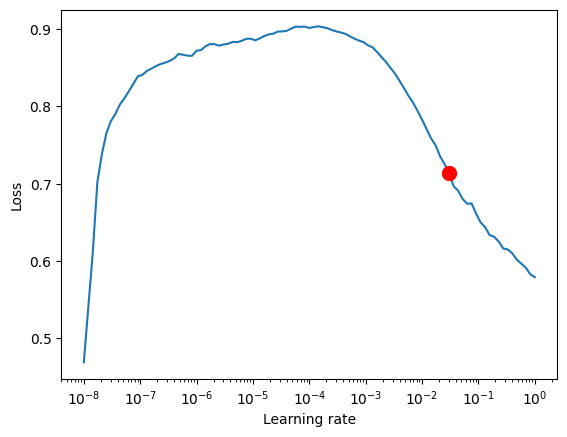

In [13]:
# Plot with
fig = lr_finder.plot(suggest=True)

# Pick point based on plot, or get suggestion
learning_rate = lr_finder.suggestion()
learning_rate

In [14]:
# зададим новый Lr модели
learning_rate = 0.01
learning_rate

0.01

## Непосредственно обучение модели

In [15]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

# создадим обратный вызов на раннюю остановку обучения
early_stop_callback = EarlyStopping(monitor="val_loss", patience=10, verbose=False, mode="min")

# создадим обратный вызов на сохранение чекпоинта модели,
# по интересующей нас метрике
# saves top-K checkpoints based on "val_loss" metric
checkpoint_callback_val_loss = ModelCheckpoint(
    save_top_k=5,
    monitor="val_loss",
    mode="min",
    filename="check_point-{epoch:02d}-{val_loss:.2f}",
)

# saves last-K checkpoints based on "global_step" metric
# make sure you log it inside your LightningModule
checkpoint_callback_last_step = ModelCheckpoint(
    save_top_k=1,
    monitor="train_step",
    mode="max",
    filename="check_point-{epoch:02d}-{train_step}",
)


In [16]:
# добавляем список обратных вызовов в параметр callbacks
trainer = pl.Trainer(accelerator="gpu", 
                     callbacks=[early_stop_callback,
                                checkpoint_callback_val_loss,
                                checkpoint_callback_last_step],
                     log_every_n_steps=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
# создаем модель для обучения
model = Classifier(
    model_name,
    input_shape,
    layer1_neurons_num,
    layer2_neurons_num,
    drop_p,
    class_labels,
    learning_rate,
)

In [18]:
# обучаем модель
trainer.fit(model, dm)

You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /home/admin-gpu/Downloads/we-love-you-all/notebooks/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | neural_net | ClassifierNet      | 21.7 K
1 | train_acc  | MulticlassAccuracy | 0     
2 | valid_acc  | MulticlassAccuracy | 0     
--------------------------------------------------
21.7 K    Trainable params
0         Non-trainable params
21.7 K    Total params
0.087     Total estimated model params size (MB)


Epoch 33: 100%|██████████| 100/100 [00:00<00:00, 110.95it/s, loss=0.152, v_num=0, train_loss=0.0734, train_acc=1.000, valid_acc_step=0.760, valid_acc_epoch=0.914, val_loss=0.238]


# Протестируем полученную модель

In [19]:
# создаем модель и загрузим веса из чекпоинта в нее
model = Classifier(
    model_name,
    input_shape,
    layer1_neurons_num,
    layer2_neurons_num,
    drop_p,
    class_labels,
    learning_rate,
)

# забираем лучшую модель
best_checkpoint_path = checkpoint_callback_val_loss.best_model_path

# модель будет в Pytorch Lightning
model = model.load_from_checkpoint(best_checkpoint_path)
model.eval()

Classifier(
  (neural_net): ClassifierNet(
    (fc1): Linear(in_features=100, out_features=128, bias=True)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop1): Dropout(p=0.3, inplace=False)
    (relu1): ReLU()
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop2): Dropout(p=0.3, inplace=False)
    (relu2): ReLU()
    (classifier): Linear(in_features=64, out_features=2, bias=True)
  )
  (train_acc): MulticlassAccuracy()
  (valid_acc): MulticlassAccuracy()
)

In [20]:
trainer = pl.Trainer(accelerator="gpu")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
# можем проверить на val части датасета
trainer.validate(model, dm)

You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 18/18 [00:00<00:00, 280.21it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.21432045102119446
     valid_acc_epoch         0.912848174571991
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'valid_acc_epoch': 0.912848174571991, 'val_loss': 0.21432045102119446}]

In [22]:
# можем проверить на test части датасета
trainer.test(model, dm)

You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 18/18 [00:00<00:00, 382.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.2074560672044754
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.2074560672044754}]

# Предсказываем на валидации

In [23]:
# предсказываем классы на тестовом датасете
model_preds = []
true_target = []

test_dataloader = dm.val_dataloader()

for batch, y in test_dataloader:
    # input_data = torch.randn(64, 100)
    input_data = batch

    logits = model(input_data)
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    model_preds.extend(predicted_class.tolist())
    true_target.extend(y.tolist())
    
model_preds = np.array(model_preds)
true_target = np.array(true_target)

In [25]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

acc_metric = accuracy_score(true_target, model_preds)
prec_metric = precision_score(true_target, model_preds, average="micro")
recall_metric = recall_score(true_target, model_preds, average="micro")
f1_metric = f1_score(true_target, model_preds, average="micro")

print(f"Модель достигает Accuracy на val part: {acc_metric}")
print(f"Модель достигает Precision на val part: {prec_metric}")
print(f"Модель достигает Recall на val part: {recall_metric}")
print(f"Модель достигает F1 на val part: {f1_metric}")

Модель достигает Accuracy на val part: 0.9101527403414196
Модель достигает Precision на val part: 0.9101527403414196
Модель достигает Recall на val part: 0.9101527403414196
Модель достигает F1 на val part: 0.9101527403414196


# Предсказываем на Test

In [26]:
# предсказываем классы на тестовом датасете
model_preds = []
true_target = []

test_dataloader = dm.test_dataloader()

for batch, y in test_dataloader:
    # input_data = torch.randn(64, 100)
    input_data = batch

    logits = model(input_data)
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    model_preds.extend(predicted_class.tolist())
    true_target.extend(y.tolist())
    
model_preds = np.array(model_preds)
true_target = np.array(true_target)
    

In [27]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

acc_metric = accuracy_score(true_target, model_preds)
prec_metric = precision_score(true_target, model_preds, average="micro")
recall_metric = recall_score(true_target, model_preds, average="micro")
f1_metric = f1_score(true_target, model_preds, average="micro")

print(f"Модель достигает Accuracy на test part: {acc_metric}")
print(f"Модель достигает Precision на test part: {prec_metric}")
print(f"Модель достигает Recall на test part: {recall_metric}")
print(f"Модель достигает F1 на test part: {f1_metric}")

Модель достигает Accuracy на test part: 0.9074573225516622
Модель достигает Precision на test part: 0.9074573225516622
Модель достигает Recall на test part: 0.9074573225516622
Модель достигает F1 на test part: 0.9074573225516622


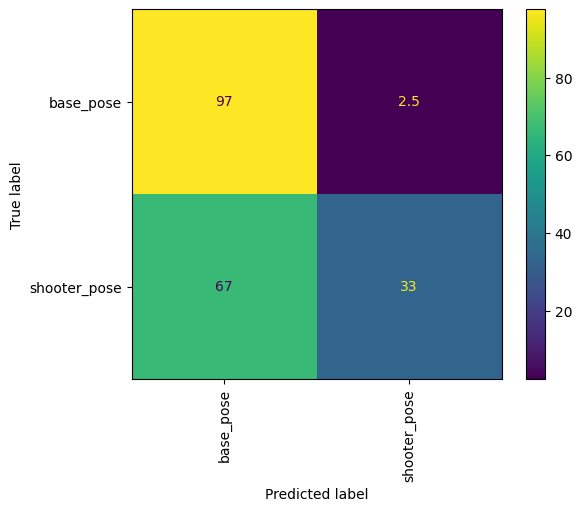

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def confision_matrix_as_picture(y_preds, y_true, class_labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    cm = np.round((cm * 100), 2)

    ConfusionMatrixDisplay(cm, display_labels=class_labels).plot(
        xticks_rotation="vertical"
    )
    
confision_matrix_as_picture(model_preds, true_target, class_labels)

In [30]:
# для инференса преобразуем в PyTorch без Lightning'a
torch.save(model.neural_net, "my_model.pth")
model = torch.load("my_model.pth")
os.remove("my_model.pth")
model.eval()

ClassifierNet(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (relu2): ReLU()
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [31]:
model

ClassifierNet(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (relu2): ReLU()
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)